## Gated Recurrent Unit(GRU) Model

* GRU, short for Gated Recurrent Unit, is a type of recurrent neural network (RNN) architecture that addresses some of the limitations of traditional RNNs, particularly in handling long-range dependencies and mitigating the vanishing gradient problem. GRUs are a variant of the more commonly known LSTM (Long Short-Term Memory) networks and are designed to capture dependencies over longer sequences more efficiently.

* Like other recurrent neural network architectures, GRU processes sequential data one element at a time, updating its hidden state based on the current input and the previous hidden state. At each time step, the GRU computes a “candidate activation vector” that combines information from the input and the previous hidden state. This candidate vector is then used to update the hidden state for the next time step.

* The candidate activation vector is computed using two gates: the reset gate and the update gate. The reset gate determines how much of the previous hidden state to forget, while the update gate determines how much of the candidate activation vector to incorporate into the new hidden state.

<img src="https://www.researchgate.net/publication/368401217/figure/fig3/AS:11431281179417554@1691186189285/GRU-model-structureGRU-gated-recurrent-neural-network.png"
     width="500" 
     height="600" />

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electricity-load-forecasting/train_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/continuous dataset.csv
/kaggle/input/electricity-load-forecasting/test_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/weekly pre-dispatch forecast.csv


## Install Libraries

In [2]:
!pip install statsmodels

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error, r2_score
import zipfile
from statsmodels.tsa.seasonal import seasonal_decompose

2024-07-22 09:29:02.157223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 09:29:02.157378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 09:29:02.335800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df=pd.read_csv('/kaggle/input/electricity-load-forecasting/continuous dataset.csv',index_col=[0],parse_dates=[0])

In [5]:
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


## Generate time-series data

In [6]:
data = df['nat_demand'].resample('D').mean()

In [7]:
data

datetime
2015-01-03    1069.266587
2015-01-04    1008.123596
2015-01-05    1146.682925
2015-01-06    1143.394429
2015-01-07    1144.098817
                 ...     
2020-06-23    1137.366342
2020-06-24    1131.196625
2020-06-25    1184.028708
2020-06-26    1106.277696
2020-06-27    1013.568300
Freq: D, Name: nat_demand, Length: 2003, dtype: float64

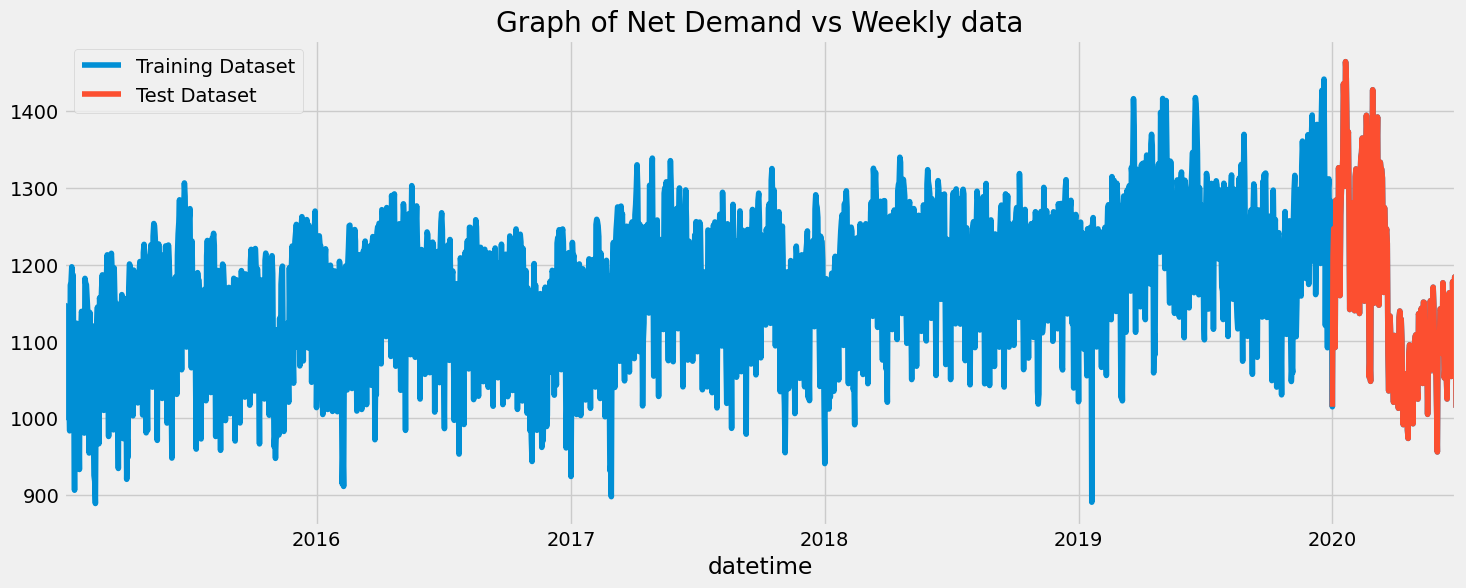

In [8]:
data[:'2020'].plot(figsize=(16,6),legend=True)
data['2020':].plot(figsize=(16,6),legend=True)
plt.legend(['Training Dataset','Test Dataset'])
plt.title('Graph of Net Demand vs Weekly data')
plt.show()

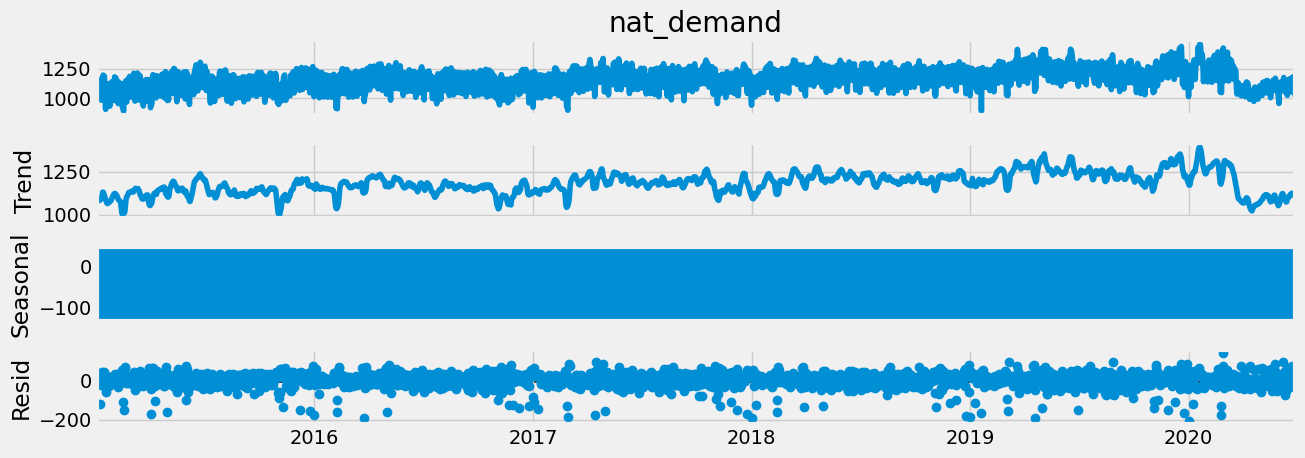

In [9]:
decomp = seasonal_decompose(data, model='additive')
fig = decomp.plot()
fig.set_figwidth(15)

In [10]:
# Checking for missing values
training_set = data[:'2020'].values
test_set = data['2020'].values
training_set=training_set.reshape((training_set.shape[0],1))
test_set=test_set.reshape((test_set.shape[0],1))

In [11]:
print("Training Set Shape : ",training_set.shape)
print("Test Set Shape : ",test_set.shape)

Training Set Shape :  (2003, 1)
Test Set Shape :  (179, 1)


## Scaling dataset in between 0 and 1

In [12]:
training_set.min(), training_set.max()

(888.8738541666667, 1464.3271791666666)

In [13]:
scalar = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scalar.fit_transform(training_set)

In [14]:
training_set_scaled, training_set_scaled.shape

(array([[0.31347935],
        [0.20722748],
        [0.44801039],
        ...,
        [0.51290842],
        [0.37779579],
        [0.21668907]]),
 (2003, 1))

In [15]:
X_train = []
Y_train = []
for i in range(100,2003):
    X_train.append(training_set_scaled[i-100:i,0])
    Y_train.append(training_set_scaled[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [17]:
X_train.shape

(1903, 100, 1)

## GRU Model

In [18]:
EPOCHS=50

model = Sequential()
model.add(GRU(64, activation='tanh',return_sequences=True, input_shape=(100, 1)))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,315 (118.42 KB)

 Trainable params: 30,315 (118.42 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(X_train,Y_train, epochs=EPOCHS, batch_size=72, shuffle=False)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 7.6454e-05 - loss: 0.0604
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 7.6454e-05 - loss: 0.0257
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 7.6454e-05 - loss: 0.0234
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 7.6454e-05 - loss: 0.0229
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 7.6454e-05 - loss: 0.0221
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 7.6454e-05 - loss: 0.0214
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 7.6454e-05 - loss: 0.0212
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 7.6454e-05 - loss: 0.0199
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 7.6454e-05 - loss: 0.0188
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 7.6454e-05 - loss: 0.0185
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 7.6454e-05 - loss: 0.0173
Epoch 12

In [20]:
dataset_total = pd.concat((data[:'2020'], data['2020':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 100:].values
inputs = inputs.reshape(-1,1)
inputs = scalar.transform(inputs)

In [21]:
X_test = []
for i in range(100,279):
    X_test.append(inputs[i-100:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_data = model.predict(X_test)
predicted_data = scalar.inverse_transform(predicted_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


In [22]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Demand')
    plt.plot(predicted, color='green',label='Predicted Demand')
    plt.title('Demand Prediction')
    plt.xlabel('Time')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

# Calculation of Root Mean Squared-Error

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

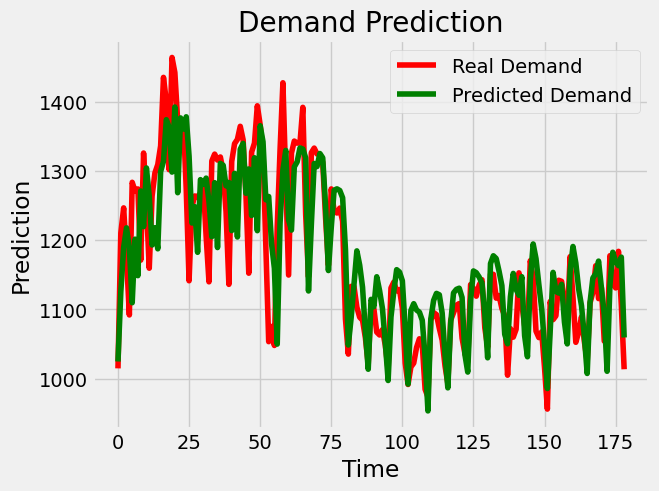

In [23]:
plot_predictions(test_set,predicted_data)

In [24]:
return_rmse(test_set,predicted_data)

The root mean squared error is 66.34879804089687.


In [25]:
r2_score(test_set,predicted_data)

0.6863093283530849